In [1]:
import json
import numpy as np
import random
from sklearn.svm import SVC
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['SimHei', 'Times New Roman']

In [2]:
class const:
    label = 'CI'  # AF,AS,MI,CI
    label_ch = '脑梗'  # 房颤,动脉粥样硬化,心梗,脑梗
    important_feature_num = 50
    confidence_score_f = '平方法'
    do_write_json_path = r'%s%s-confidence-score-dict-num=%d-func=%s-normalization.json'
    sample_num = 100

由于Svm无法处理较大的数据集（或者说处理大数据集的效果很不好）,所以一定要用抽样数据来降低数据规模

In [3]:
def prepare_svm_data(label_ch, label):
    now_json_path_file_name = const.do_write_json_path % (label_ch, label, const.important_feature_num, const.confidence_score_f)
    thresholds_dict = json.load(open(now_json_path_file_name, 'r', encoding='utf-8'))

    temp_data_true = np.array([thresholds_dict["true"]["pred_pro_mean"],thresholds_dict["true"]["pred_pro_confidence"]])
    sample_list = random.sample([i for i in range(temp_data_true.shape[1])], const.sample_num)
    pred_pro_mean_true = list(temp_data_true[:,sample_list][0])
    pred_pro_confidence_true_normalization = list(temp_data_true[:,sample_list][1])

    temp_data_false = np.array([thresholds_dict["false"]["pred_pro_mean"],thresholds_dict["false"]["pred_pro_confidence"]])
    sample_list = random.sample([i for i in range(temp_data_false.shape[1])], const.sample_num)
    pred_pro_mean_false = list(temp_data_false[:,sample_list][0])
    pred_pro_confidence_false_normalization = list(temp_data_false[:,sample_list][1])
    
    x = np.array([pred_pro_mean_true + pred_pro_mean_false, pred_pro_confidence_true_normalization + pred_pro_confidence_false_normalization])
    y = np.concatenate((np.ones(const.sample_num), np.zeros(const.sample_num))).astype(int)
    return x.T, y

In [4]:
def common_data():
    ## 生成等高线网格数据
    x0s = np.linspace(0, 1, 200)  # 创建等差数列，从 start 到 stop，共 num 个
    x1s = np.linspace(0, 1, 200)  # start, stop 根据数据范围选择确定
    x0, x1 = np.meshgrid(x0s, x1s)  # 生成网格点坐标矩阵
    x_test = np.c_[x0.ravel(), x1.ravel()]  # 返回展平的一维数组
    return x0, x1, x_test

In [5]:
def prepare_svm_pred(x, y, x_test, x0):
    svm_pred_dict_ = {}
    for index, now_kernel in enumerate(['linear', 'poly', 'rbf', 'sigmoid']):
        # SVC 建模，训练和输出
        model_svm = SVC(kernel=now_kernel)
        model_svm.fit(x, y)  # 用样本集 x,y 训练支持向量机
        y_pred = model_svm.predict(x_test).reshape(x0.shape)  # 用模型 1 预测分类结果
        svm_pred_dict_[now_kernel] = y_pred
    return svm_pred_dict_

In [6]:
def plot_svc(x, y, x0, x1, svm_pred_dict, label_ch):
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))  # 创建带有指定大小的子图
    for index, now_kernel in enumerate(['linear', 'poly', 'rbf', 'sigmoid']):
        axs[index].contourf(x0, x1, svm_pred_dict[now_kernel], alpha=0.1)  # 绘制模型1 分类结果
        axs[index].scatter(x[:, 0][y == 1], x[:, 1][y == 1], label='正确分类', c='k', s=5)  # 按分类绘制数据样本点
        axs[index].scatter(x[:, 0][y == 0], x[:, 1][y == 0], label='错误分类', c='r', s=5)
        axs[index].legend(loc="lower right", shadow=True, fancybox=True)
        axs[index].grid(True, which='both')
        axs[index].set_title(now_kernel)
        # axs[index].xlabel('目标疾病预测概率')
        # axs[index].ylabel('置信得分')
    plt.suptitle(label_ch)
    plt.tight_layout()  # 调整布局
    plt.show()  # 显示图形

In [7]:
def do_work(label_ch, label):
    ## 准备数据
    x, y = prepare_svm_data(label_ch, label)
    x0, x1, x_test = common_data()
    ## 获取svm
    svm_pred_dict = prepare_svm_pred(x, y, x_test, x0)
    plot_svc(x, y, x0, x1, svm_pred_dict, label_ch)

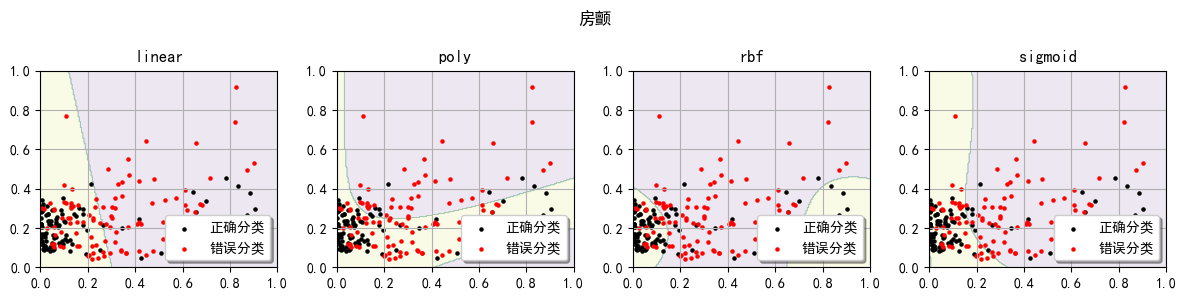

In [8]:
do_work('房颤', 'AF')

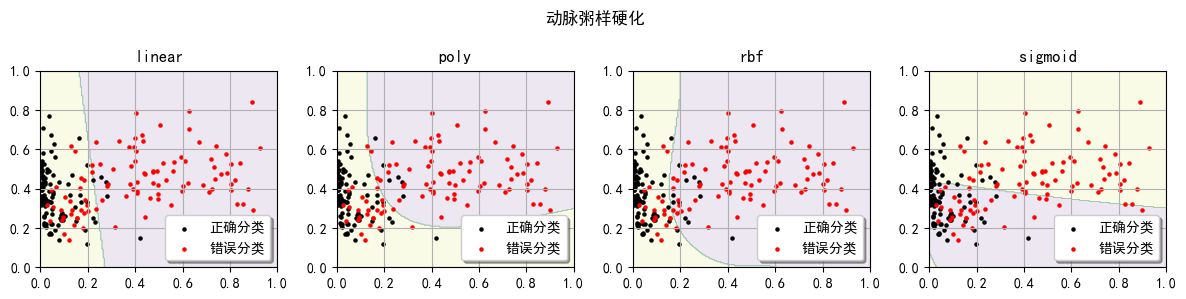

In [9]:
do_work('动脉粥样硬化', 'AS')

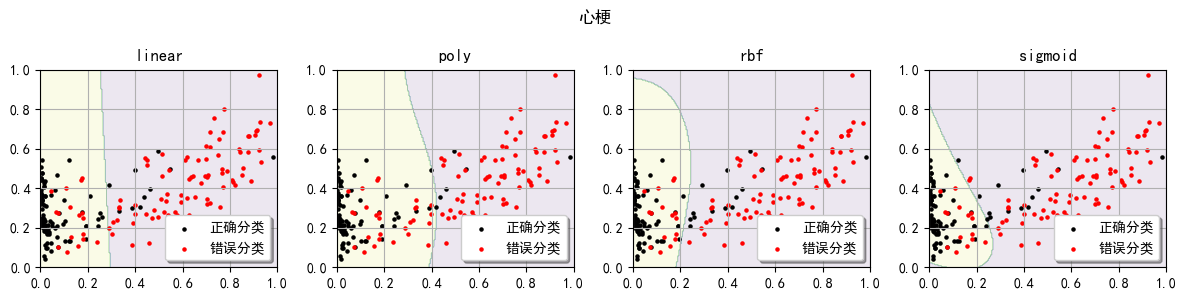

In [10]:
do_work('心梗', 'MI')

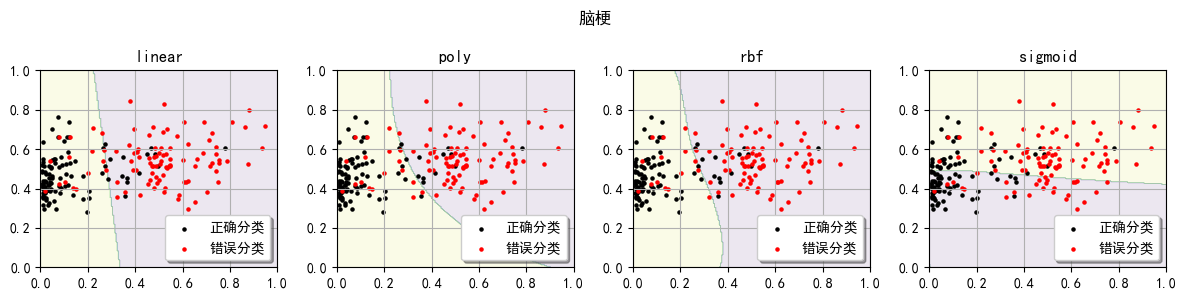

In [11]:
do_work('脑梗', 'CI')